# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 
1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.3 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.8 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [142]:
import numpy as np
# Не печатать в лог сообщения о делении на ноль, ибо так и должно быть
np.seterr(divide='ignore', invalid='ignore')
import logging as log
import sys
log.basicConfig(level=log.INFO, format='>%(message)s', stream=sys.stdout)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

#пример из листочка 1
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
# (array([ 4.,  0.]), 20.0, 1)

In [248]:
class SP:
    def __init__(self, A, b, c):
        self.A = A
        b = b.reshape((-1, 1)).astype(np.float64)
        self.b = b
        self.c = c
        
        self.n = n = A.shape[0]
        self.m = m = A.shape[1]
        log.info('n=%s, m=%s'%(n, m))

        self.basis = list(range(0, n))
        self.nonbasis = list(range(n, n+m))
        log.debug("basis %s, nonbasis %s"%(self.basis, self.nonbasis))
        
        # Сделаем симплекс-таблицу.
        self.ST = np.block([[A,  b], 
                      [-c, 0]]).astype(np.float64)
        log.info('%s'%self.ST)
    
    def __str__(self):
        return "%s\nn=%s, m=%s, basis=%s, nonbasis=%s"%(self.ST, self.n, self.m, self.basis, self.nonbasis)


In [269]:
def draw_all(sp, path):
    
    A = sp.A
    b = sp.b
    c = sp.c
    
    def is_valid_solution(x):
        return (A@x.reshape((-1,1))<=b).all() and (x>=0).all()

    # Добавляем прямые ограничений типа >=0 в матрицы.
    A_plot = np.vstack([A, np.array([[1,0], [0,1]])])
    b_plot = np.vstack([b, [[0],[0]]])

    num_iter = len(path)
    plt.figure(figsize=(5, 5*(num_iter+1)))
    # Рисует ограничения, допустимые угловые точки отмечает чёрными точками, текущую - красной.
    for i, x in enumerate(path):
        plt.subplot(num_iter, 1, i+1)
        a = plt.gca()
        #plt.axes().set_aspect('equal')#, 'datalim')
        ##a.axis([-1, 17, -1, 17])
        a.set_aspect('equal')
        a.set_xlabel('X1')
        a.set_ylabel('X2')
        plt.title('Iteration %d x=(%.2f, %.2f)' % (i+1,x[0],x[1]))

        xmax, ymax = 0,0
        # Пересечения
        for i in range(0, A_plot.shape[0]):
            for j in range(0, i):
                if i != j:
                    a_, b_ = A_plot[i]
                    c_ = b_plot[i][0]
                    d_, e_ = A_plot[j]
                    f_ = b_plot[j][0]
                    #print(a_, b_, c_, d_, e_, f_)
                    x_ = (b_*f_-c_*e_)/(b_*d_-a_*e_)
                    y_ = (c_*d_-a_*f_)/(b_*d_-a_*e_)#(c_-a_*x_)/b_
                    if x_ > xmax and x_ != np.inf:
                        xmax = x_
                    if y_ > ymax and y_ != np.inf:
                        ymax = y_
                    #print(x_, y_)
                    if is_valid_solution(np.array([x_, y_])):
                        plt.scatter([x_], [y_], color='black', zorder=10)
        plt.scatter([x[0]], [x[1]], color='red', zorder=11)

        #print('xmax ymax', xmax, ymax)
        # Ограничения в виде осей (неотрицательность переменных)
        plt.plot([0, xmax], [0, 0], color='blue')
        plt.plot([0, 0], [ymax, 0], color='blue')
        epsilon = 2
        plt.xlim((-epsilon, xmax+epsilon))
        plt.ylim((-epsilon, ymax+epsilon))

        # Ограничения
        for i in range(0, A_plot.shape[0]):
            a_, b_ = A_plot[i]
            c_ = b_plot[i][0]
            #print(a_, b_, c_)
            #print(c_/b_, c_/a_)
            #plt.plot([0, c_/a_], [c_/b_, 0], color='blue')

            if c_/b_<0:
                x1, y1 = c_/a_, 0
            else:
                x1, y1 = 0, c_/b_
            if (c_-a_*xmax)/b_ > ymax:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            else:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue')

            if c_/a_<0:
                x1, y1 = 0, c_/b_
            else:
                x1, y1 = c_/a_, 0
            if (c_-a_*xmax)/b_ < ymax:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            else:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue', zorder=-1)

            # Дорисовываем оси до нашей точки.
            #plt.plot([0, c_/a_], [0, 0], color='blue')
            #plt.plot([0, 0], [c_/b_, 0], color='blue')


    #plt.tight_layout()
    plt.show()

In [273]:
def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции если это необходимо
    
    A, b, c - матрица, b - вектор ограничений типа <=, с - функция полезности, задача максимизации
    method - 'blend', 'lexical'
    start_point - точка
    draw -  true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор на котором достигается максимум, максимальное значение, число итераций
    """
    
    def get_solution(sp):
        ST = sp.ST
        basis = sp.basis
        nonbasis = sp.nonbasis
        n = sp.n
        m = sp.m
        
        x = np.zeros(m)
        w = np.zeros(n)
        for i in range(0, n):
            if 0<=basis[i]<n:
                w[basis[i]] = ST[:,-1][i]
            if basis[i]>=n:
                x[basis[i]-n] = ST[:,-1][i]
        log.info('%s %s', x, w)
        return x, w
    
    def get_variables(sp, method):
        ST = sp.ST
        basis = sp.basis
        nonbasis = sp.nonbasis
        n = sp.n
        m = sp.m
        
        if method=='init_auxilary':
            return np.argmin(ST[-1]), m+n
        if method=='largest_coef':
            j = np.argmin(ST[-1][:-1])
        elif method=='blend':
            j = np.argmin(np.ma.array(nonbasis, mask=(ST[-1][:-1]>=0)))
        elif method=='lexical':
            j = 0 #TODO

        ratios = ST[:, -1]/ST[:, j]
        i = np.argmin(np.ma.array(ratios[:-1], mask=(ratios[:-1]<0)))
        
        log.info('j=%s'%j)
        log.debug('%s'%ratios)
        log.info('i=%s'%i)
        return i, j

    def make_iteration(variables, sp):
        ST = sp.ST
        basis = sp.basis
        nonbasis = sp.nonbasis
        n = sp.n
        m = sp.m
        
        #Разрешающий столбец
        log.debug('%s'%ST[-1])
        i, j = variables

        #Строим новую таблицу
        ST_ = ST.copy()
        basis[i], nonbasis[j] = nonbasis[j], basis[i]
        log.info("basis %s, nonbasis %s"%(basis, nonbasis))
        ST_[i][j] = 1/ST[i][j]
        log.debug("%s"%ST_)
        ST_[i][np.arange(m+1) != j] = ST[i][np.arange(m+1) != j]/ST[i][j]
        log.debug("%s"%ST_)
        ST_[:, j][np.arange(n+1) != i] = -ST[:, j][np.arange(n+1) != i]/ST[i][j]
        log.debug("%s"%ST_)

        for i_ in range(0, n+1):
            for j_ in range(0, m+1):
                if i_ != i and j_ != j:
                    ST_[i_][j_] = ST[i_][j_] - ST[i_][j]*ST[i][j_]/ST[i][j]

        log.info("%s"%ST_)
        sp.ST = ST_
        return sp
    
    # Если есть отрицательные значения в b, запускаем инициализацию
    if (b < 0).any():
        log.info("             AUXILARY PROBLEM:")
        A_ = np.hstack([A, np.ones((A.shape[0], 1))])
        b_ = b
        c_ = np.hstack([np.zeros(A.shape[1]), [-1]])
        sp = SP(A_, b_, c_)
        
        sp = make_iteration(get_variables(sp, 'init_auxilary'), sp)
        
        while np.min(sp.ST[-1]) < 0:
            iteration_number += 1
            log.info('          AUXILARY ITERATION #%s'%iteration_number)

            sp = make_iteration(get_variables(sp, method), sp)

            x, w = get_solution(sp)
        

    iteration_number = 0
    
    sp = SP(A, b, c)
    print(sp)
    
    # Начальное решение
    x, w = get_solution(sp)
    solutions = [x]
    
    while np.min(sp.ST[-1]) < 0:
        iteration_number += 1
        log.info('          ITERATION #%s'%iteration_number)
        
        sp = make_iteration(get_variables(sp, method), sp)
        
        x, w = get_solution(sp)
        solutions.append(x)
    
    log.info('FINISHED in %d iterations'%iteration_number)
    
    log.info('path %s'%solutions)
    x, w = get_solution(sp)
    
    log.info('SOLUTIONS %s'%solutions)
    
    if draw == True and sp.m != 2:
        raise Exception("Can't draw with dim != 2")
        
    if draw == True:
        draw_all(sp, solutions)
    
    return x, sp.ST[-1][-1], iteration_number


>n=2, m=2
>[[ 1.   2.   5. ]
 [ 2.   0.5  8. ]
 [-5.  -1.   0. ]]
[[ 1.   2.   5. ]
 [ 2.   0.5  8. ]
 [-5.  -1.   0. ]]
n=2, m=2, basis=[0, 1], nonbasis=[2, 3]
>[ 0.  0.] [ 5.  8.]
>          ITERATION #1
>j=0
>i=1
>basis [0, 2], nonbasis [1, 3]
>[[ -0.5    1.75   1.  ]
 [  0.5    0.25   4.  ]
 [  2.5    0.25  20.  ]]
>[ 4.  0.] [ 1.  0.]
>FINISHED in 1 iterations
>path [array([ 0.,  0.]), array([ 4.,  0.])]
>[ 4.  0.] [ 1.  0.]
>SOLUTIONS [array([ 0.,  0.]), array([ 4.,  0.])]


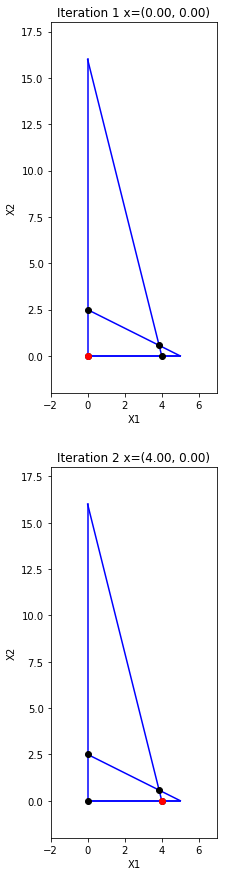

>             AUXILARY PROBLEM:
>n=2, m=3
>[[-1.  -2.   1.  -5. ]
 [-2.  -0.5  1.  -1. ]
 [-0.  -0.   1.   0. ]]


IndexError: list index out of range

In [274]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True)
corr_ans = (np.array([ 4.,  0.]), 20.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
print(solve_dual(A, b, c))

A=np.array([[1,-1],[2,-1], [0, 1]])
b=np.array([1,3,5])
c=np.array([4,3])
ans = solve_lin_prog(A, b, c, draw=True)
corr_ans = (np.array([ 4.,  5.]), 31.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
print(solve_dual(A, b, c))
#print(is_optimal(A,b,c,x))

A=np.array([[2,3,1],[4,1,2],[3,4,2]])
b=np.array([5, 11, 8])
c=np.array([5, 4, 3])
ans = solve_lin_prog(A, b, c)
corr_ans = (np.array([ 2.,  0.,  1.]), 13.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
print(solve_dual(A, b, c))

A=np.array([[1,1,1,1],[2,1,-1,-1],[0,-1,0,1]])
b=np.array([40, 10, 10])
c=np.array([0.5, 3,1,4])
ans = solve_lin_prog(A, b, c)
corr_ans = (np.array([  0.,  15.,   0.,  25.]), 145.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
print(solve_dual(A, b, c))

>n=2, m=2
>[[-1.  -2.  -5. ]
 [-2.  -0.5 -1. ]
 [ 5.   8.   0. ]]
[[-1.  -2.  -5. ]
 [-2.  -0.5 -1. ]
 [ 5.   8.   0. ]]
n=2, m=2, basis=[0, 1], nonbasis=[2, 3]
>[ 0.  0.] [-5. -1.]
>FINISHED in 0 iterations
>path [array([ 0.,  0.])]
>[ 0.  0.] [-5. -1.]
>SOLUTIONS [array([ 0.,  0.])]


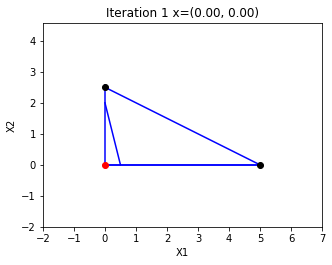

In [272]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
A=np.array([[-1,-2],[-2,-0.5]])
c=np.array([-5,-8])
b=np.array([-5,-1])
x, best, n_iter = solve_lin_prog(A,b,c, draw=True)

In [148]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

Точка:  [ 4.  0.]
Ответ:  20.0
Число итераций:  1


In [159]:

# c = np.array([1, -1])
# A = np.array([[-2, 1],
#               [1, -2],
#                [1, 1]])
# b = np.array([2, 2, 5])
# x = np.array([1,4])
# x = np.array([4,1])

def solve_dual(A, b, c):
    return solve_lin_prog(-A.T, -c, -b)

def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    # Если точка недопустима, она не оптимальна
    if (A@x>b).any() or (x < 0).any():
        return False
    A_ = -A.T
    c_ = -b
    b_ = -c
    print(A_, b_, c_)
    not_zeros_in_dual = (A@x == b)
    print(A_[:,not_zeros_in_dual])
    x_nonzero = np.linalg.solve(A_[:,not_zeros_in_dual], b_)
    print(x_nonzero)
    
    
    x_ = np.zeros(A_.shape[1])
    x_[not_zeros_in_dual] = x_nonzero
    print(x_)
    # Если для двойственной задачи её точка недопустима, то у прямой точка была не оптимальной.
    if (A_@x_ > b_).any() or (x_ < 0).any():
        return False
    
    return True

In [150]:
is_optimal(A,b,c,x)

[[-1.  -2. ]
 [-2.  -0.5]] [-5 -1] [-5 -8]
[[-2. ]
 [-0.5]]


LinAlgError: Last 2 dimensions of the array must be square

# ==========================================================
# Задача на МНК (0.4 балла)

In [70]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t,a): 
    return a[2]*sin(t)+a[1]*t +a[0]

def y_vector(t, a):
    return [y(t_, a) for t_ in t]

"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m=200
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, σ):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,σ,m)
    return y_real, y_corr

#todo -выбрать параметр
#σ=0.5
σ=1000

#генерация значений. изначальные и с помехами
y_real, y_corr= get_y(a,σ)


def get_params (y_corr, t, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    A = np.matrix([[1, t_, np.sin(t_)] for t_ in t])
    y_corr = y_corr.reshape(-1,1)
    if method == 0:
        return ((A.T@A).I @ A.T @ y_corr).A1
    elif method == 1:
        E = np.eye(A.shape[0])
        ST = np.bmat([[-E, A],
                      [-E, -A]])
        
        b = np.vstack([y_corr, -y_corr])
        c = -np.hstack([np.ones(A.shape[0]), np.zeros(A.shape[1])]) # Точно с минусом?
        print(A.shape, ST.shape, b.shape, c.shape)
        x, _, _ = solve_lin_prog(ST, b, c)
        print(x)
        return x
    elif method == 2:
        ones = np.ones(A.shape[0]).reshape(-1,1)
        ST = np.bmat([[-ones, A],
                      [-ones, -A]])
        b = np.vstack([y_corr, -y_corr])
        c = -np.hstack([[1], np.zeros(A.shape[1])])
        print(A.shape, ST.shape, b.shape, c.shape)
        
        x, _, _ = solve_lin_prog(ST, b, c)
        print(x)
        return x

## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [71]:
def analyze_approximation(t, y_corr):
    plt.figure(figsize=(10, 5))
    plt.plot(t, y_vector(t, a), color='black')
    plt.scatter(t, y_corr, color='gray', alpha=0.5)
    a_est = get_params(y_corr, t)
    print('For method=0', a_est)
    plt.plot(t, y_vector(t, a_est), color='r')
    a_est = get_params(y_corr, t, method=1)
    print('For method=1', a_est)
    plt.plot(t, y_vector(t, a_est), color='g')
    a_est = get_params(y_corr, t, method=2)
    print('For method=2', a_est)
    plt.plot(t, y_vector(t, a_est), color='b')
    plt.show()

For method=0 [  63.79602117  104.99858099  854.913661  ]
(200, 3) (400, 203) (400, 1) (203,)
>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.10982329e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   5.00000000e-02
    4.99791693e-02   1.63443040e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.00000000e-01
    9.98334166e-02   3.03286494e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.90000000e+00
    4.57535894e-01  -6.88608192e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.95000000e+00
    5.01405128e-01  -3.45113292e+02]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
>n=400, m=203
>FINISHED in 0 iterations
>path [array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
For method=1 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.

[ 0.  0.  0.  0.]
For method=2 [ 0.  0.  0.  0.]


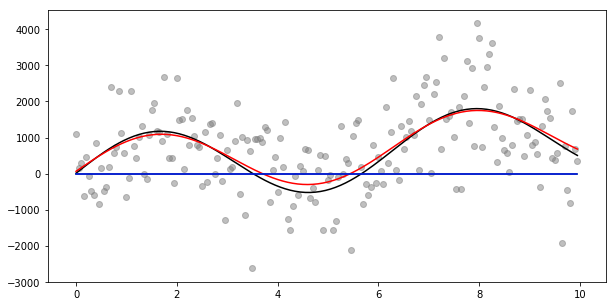

In [72]:
analyze_approximation(t, y_corr)

(200, 3) (400, 203) (400, 1) (203,)
>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   6.82221921e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   5.00000000e-02
    4.99791693e-02  -1.28748225e+03]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.00000000e-01
    9.98334166e-02  -1.52378740e+03]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.90000000e+00
    4.57535894e-01  -3.40093106e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.95000000e+00
    5.01405128e-01  -8.17092587e+02]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
>n=400, m=203
>FINISHED in 0 iterations
>path [array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
(200, 3) (400, 4) (400, 1) (4,)
>[[ -1.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    6.82221921e+02]
 [ -1.00000000e+00   1.00000000e+00   5.00000000e-02

[ 0.  0.  0.  0.]


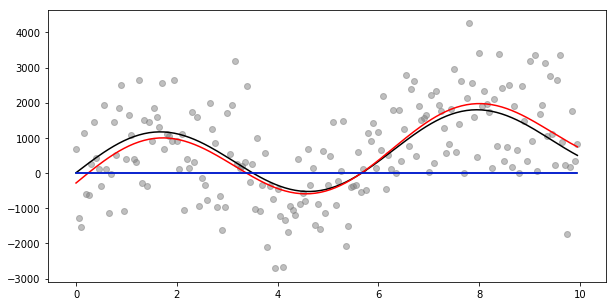

In [129]:
y_corr_with_outlier = y_corr.copy()
y_corr_with_outlier[0] += 50
y_corr_with_outlier[-1] -= 50

analyze_approximation(t, y_corr_with_outlier)

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [7]:
A = np.random.normal(size=(200, 80))
b = np.random.normal(size=(200))



## Бонус +1 Балл
Напишите программу которая для обоих методов из задачи 5 будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)